In [2]:
import numpy as np
import matplotlib.pyplot as plt

import cv2, os
from PIL import Image

from skimage.metrics import structural_similarity as ssim

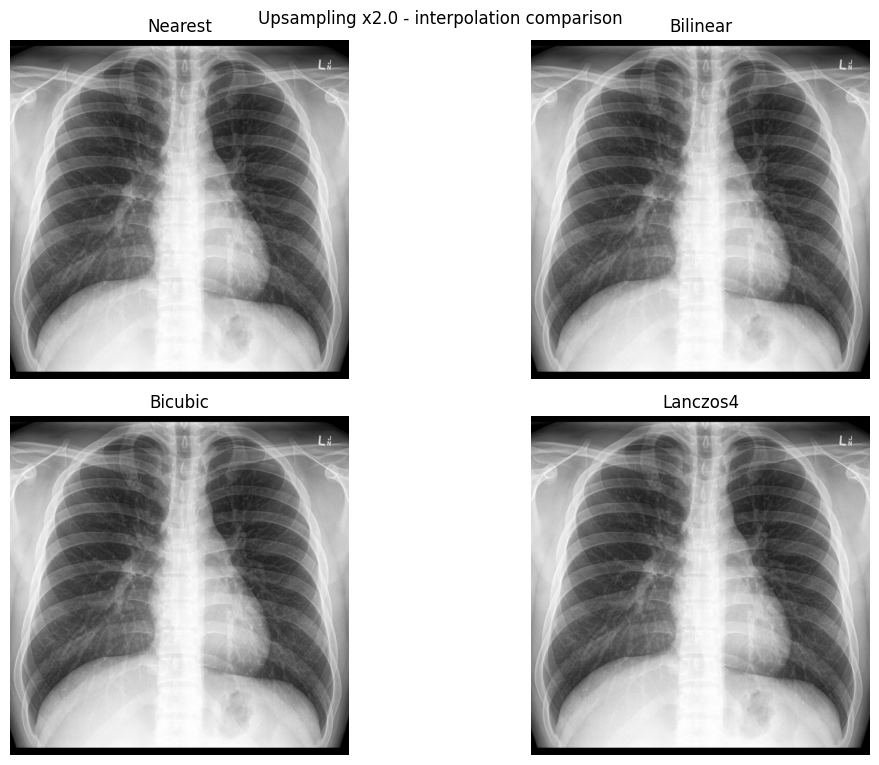

In [13]:
# 1) โหลดภาพ
objects = os.path.join(os.getcwd(), "images", "chest.jpg")
img = cv2.imread(objects, cv2.IMREAD_COLOR)

if img is None:
    raise FileNotFoundError(f"Cannot read image. Check path: {objects}")

# 2) กำหนด scale (ถ้าต้องการ upsampling x2 ให้ใช้ 2.0)
scale = 2.0

# 3) แกะ h,w อย่างปลอดภัย (รองรับภาพสี/เทา)
h, w = img.shape[:2]
new_size = (int(w * scale), int(h * scale))  # (width, height)

# 4) ทำ interpolation หลายแบบ
up_nearest  = cv2.resize(img, new_size, interpolation=cv2.INTER_NEAREST)
up_bilinear = cv2.resize(img, new_size, interpolation=cv2.INTER_LINEAR)
up_bicubic  = cv2.resize(img, new_size, interpolation=cv2.INTER_CUBIC)
up_lanczos  = cv2.resize(img, new_size, interpolation=cv2.INTER_LANCZOS4)

# 5) แปลง BGR -> RGB เพื่อแสดงผลใน matplotlib ให้สีถูกต้อง
def bgr2rgb(im):
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

imgs = [
    ("Nearest",  bgr2rgb(up_nearest)),
    ("Bilinear", bgr2rgb(up_bilinear)),
    ("Bicubic",  bgr2rgb(up_bicubic)),
    ("Lanczos4", bgr2rgb(up_lanczos)),
]

plt.figure(figsize=(12, 8))
for i, (title, im) in enumerate(imgs, start=1):
    plt.subplot(2, 2, i)
    plt.imshow(im)
    plt.title(title)
    plt.axis("off")

plt.suptitle(f"Upsampling x{scale:.1f} - interpolation comparison", y=0.95)
plt.tight_layout()
plt.show()

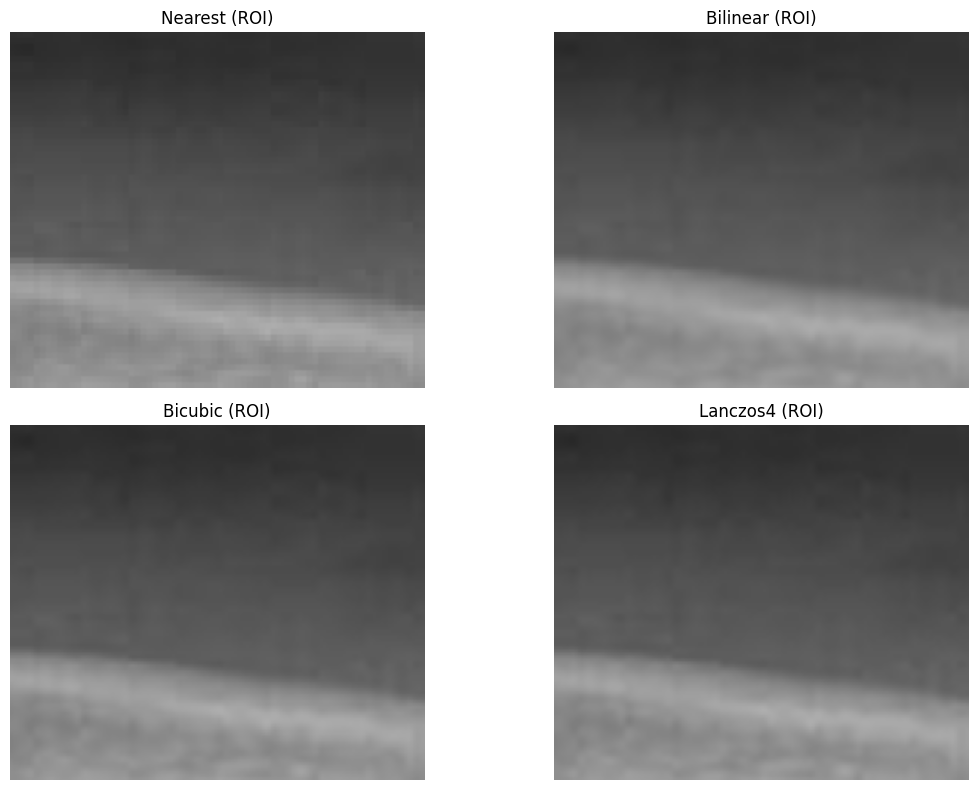

In [14]:
# เลือก ROI (ปรับพิกัดให้ตรงกับภาพของท่าน)
y0, y1 = 80, 200
x0, x1 = 120, 260

plt.figure(figsize=(12,8))
for i, (title, im) in enumerate(imgs, start=1):
    plt.subplot(2, 2, i)
    plt.imshow(im[y0:y1, x0:x1])
    plt.title(title + " (ROI)")
    plt.axis("off")
plt.tight_layout()
plt.show()

| Method   | ความคม  | ความเรียบ | Blur   | Ringing  | ลักษณะขอบ                |
| -------- | ------- | --------- | ------ | -------- | ------------------------ |
| Nearest  | ต่ำ     | ต่ำ       | ไม่มี  | ไม่มี    | ขอบจะ “หยักเป็นขั้นบันได” (blocky edge)                  |
| Bilinear | ปานกลาง | ปานกลาง   | มี     | ไม่มี    | smooth blur              |
| Bicubic  | สูง     | สูง       | น้อย   | เล็กน้อย | sharp + halo             |
| Lanczos  | สูงมาก  | สูง       | ต่ำมาก | อาจมี    | very sharp + oscillation |


- PSNR = Peak Signal-to-Noise Ratio: PSNR สูง → MSE ต่ำ → error ต่ำ
- SSIM = Structural Similarity Index Measure: โดยพิจารณา 3 ส่วน:
Luminance (ความสว่าง),Contrast (ความต่างระดับ),Structure (โครงสร้าง)
SSIM ใกล้ 1 → โครงสร้างภาพใกล้เคียงกันมาก
- ความหมายของสีใน diff map
สีดำ	ความแตกต่างต่ำมาก หรือแทบไม่มี ในบริเวณภายในของรูป
สีม่วง/ชมพู	ความแตกต่างสูง มักเกิดบริเวณขอบ

Original image shape: (H, W, C) = (320, 320, 3)
Target size: (W, H) = (1524, 1524)


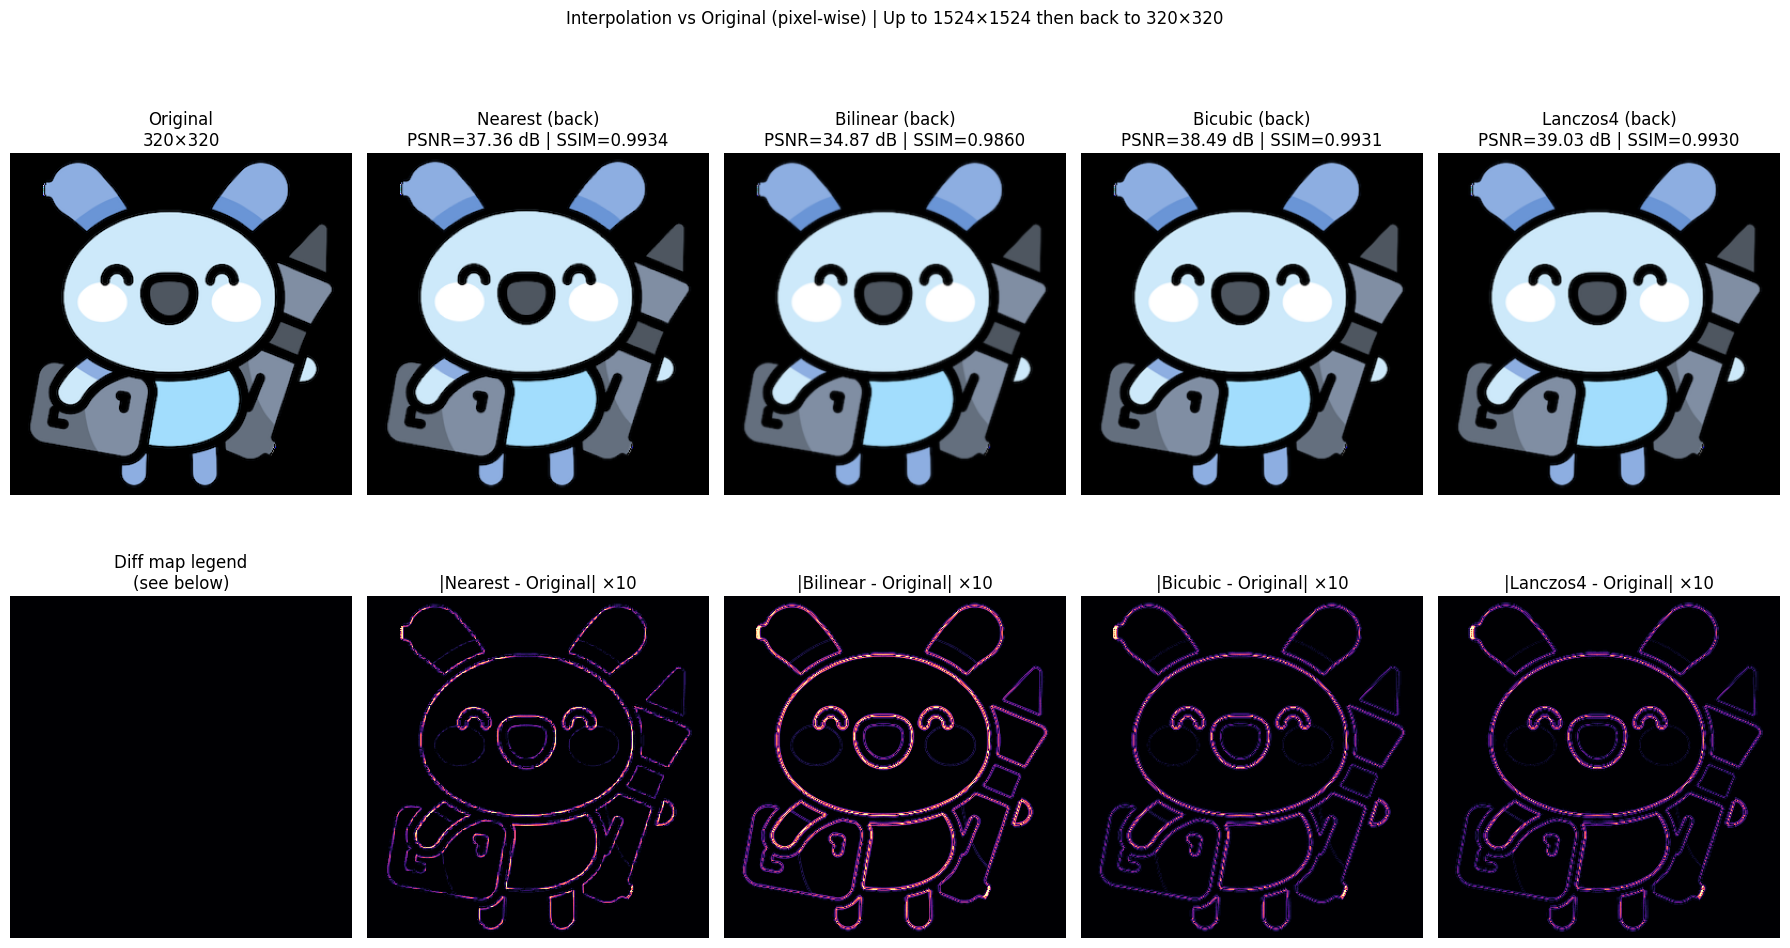

In [51]:
# Up-sample → Down-sample กลับ → เปรียบเทียบกับ Original

objects = os.path.join(os.getcwd(), "images", "cartoonicon.png")
img = cv2.imread(objects, cv2.IMREAD_COLOR)
if img is None:
    raise FileNotFoundError(f"Cannot read: {objects}")

orig_h, orig_w = img.shape[:2]
orig_c = img.shape[2] if img.ndim == 3 else 1
print(f"Original image shape: (H, W, C) = ({orig_h}, {orig_w}, {orig_c})")

# 2) Target size
target_w, target_h = 1524, 1524
print(f"Target size: (W, H) = ({target_w}, {target_h})")

# 3) Interpolations for upsampling
methods = {
    "Nearest":  cv2.INTER_NEAREST,
    "Bilinear": cv2.INTER_LINEAR,
    "Bicubic":  cv2.INTER_CUBIC,
    "Lanczos4": cv2.INTER_LANCZOS4
}

# 4) Utility: BGR -> RGB for display
def to_display(im):
    if im.ndim == 2:
        return im
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# 5) Metrics (on grayscale to make it simple and stable)
def to_gray01(bgr):
    g = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
    return g

def psnr(a, b, data_range=1.0):
    mse = np.mean((a - b) ** 2)
    if mse < 1e-12:
        return float("inf")
    return 10 * np.log10((data_range**2) / mse)

orig_gray = to_gray01(img)

results = {}
for name, inter in methods.items():
    up = cv2.resize(img, (target_w, target_h), interpolation=inter)
    # Downsample back to original size (important: comparable to original)
    back = cv2.resize(up, (orig_w, orig_h), interpolation=cv2.INTER_AREA)

    back_gray = to_gray01(back)
    diff = np.abs(back_gray - orig_gray)  # 0..1

    results[name] = {
        "up": up,
        "back": back,
        "diff": diff,
        "psnr": psnr(orig_gray, back_gray),
        "ssim": ssim(orig_gray, back_gray, data_range=1.0)
    }

# 6) Plot: Original + (Back-to-original) + Diff maps
plt.figure(figsize=(18, 10))

# Row 1: Original and reconstructed (back) images
plt.subplot(2, 5, 1)
plt.imshow(to_display(img))
plt.title(f"Original\n{orig_w}×{orig_h}")
plt.axis("off")

for i, name in enumerate(methods.keys(), start=2):
    back = results[name]["back"]
    p = results[name]["psnr"]
    s = results[name]["ssim"]
    plt.subplot(2, 5, i)
    plt.imshow(to_display(back))
    plt.title(f"{name} (back)\nPSNR={p:.2f} dB | SSIM={s:.4f}")
    plt.axis("off")

# Row 2: Diff maps (amplified for visibility)
# NOTE: diff มักเล็กมาก ต้องขยายเพื่อให้เห็น
amp = 10  # ปรับเป็น 5, 10, 20 ได้
plt.subplot(2, 5, 6)
plt.imshow(np.zeros_like(orig_gray), cmap="magma", vmin=0, vmax=1)
plt.title("Diff map legend\n(see below)")
plt.axis("off")

for i, name in enumerate(methods.keys(), start=7):
    diff = results[name]["diff"]
    plt.subplot(2, 5, i)
    plt.imshow(np.clip(diff * amp, 0, 1), cmap="magma", vmin=0, vmax=1)
    plt.title(f"|{name} - Original| ×{amp}")
    plt.axis("off")

plt.suptitle(
    f"Interpolation vs Original (pixel-wise) | Up to {target_w}×{target_h} then back to {orig_w}×{orig_h}",
    y=1.02
)
plt.tight_layout()
plt.show()

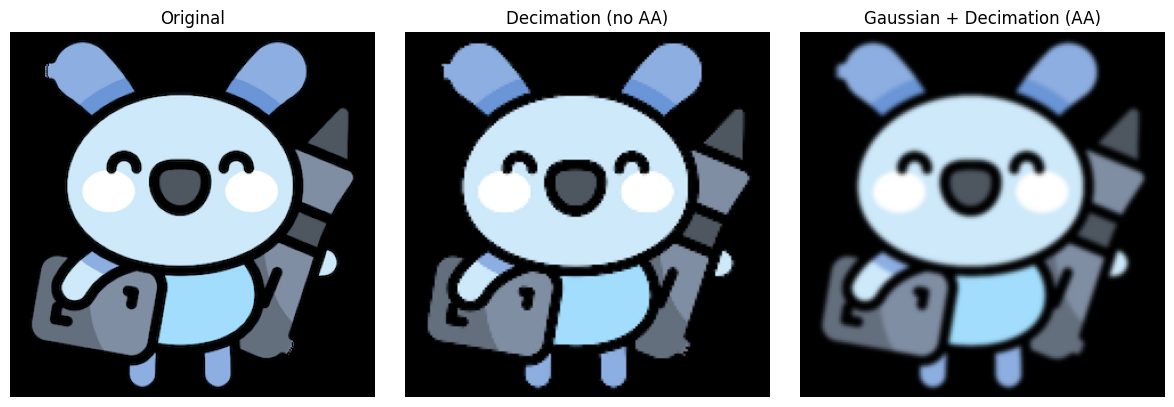

In [ ]:
# img เป็น BGR จาก cv2.imread
sigma = 1.8
blur = cv2.GaussianBlur(img, (0,0), sigmaX=sigma, sigmaY=sigma)

decim = img[::2, ::2] # การลดจำนวนตัวอย่าง (samples) ของสัญญาณหรือภาพ โดยการ “ลดอัตราการสุ่มตัวอย่าง” (downsampling) ลงด้วยการเลือกเฉพาะบางพิกเซลตามช่วงที่กำหนด
aa_decim = blur[::2, ::2] # ทำให้เบลอก่อนแล้วค่อย downsampling ป้องกันการเกิด Aliasing 

# Aliasing คือปรากฏการณ์ที่เกิดขึ้นเมื่อสัญญาณ (เช่น ภาพ) ถูกสุ่มตัวอย่าง (sampling) หรือถูกลดอัตราการสุ่มตัวอย่าง (downsampling) 
# โดยที่ยังมีองค์ประกอบความถี่สูงเกินกว่าที่ sampling ใหม่จะรองรับได้ ทำให้ข้อมูลความถี่สูง “ปลอมตัว” (masquerade) เป็นความถี่ต่ำ และก่อให้เกิดความเพี้ยนที่ไม่สามารถแก้ไขย้อนกลับได้

# แปลงเป็น RGB เพื่อแสดงผลให้สีถูกต้อง
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
decim_rgb = cv2.cvtColor(decim, cv2.COLOR_BGR2RGB)
aa_decim_rgb = cv2.cvtColor(aa_decim, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img_rgb);      plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(decim_rgb);    plt.title("Decimation (no AA)"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(aa_decim_rgb); plt.title("Gaussian + Decimation (AA)"); plt.axis("off")
plt.tight_layout()
plt.show()

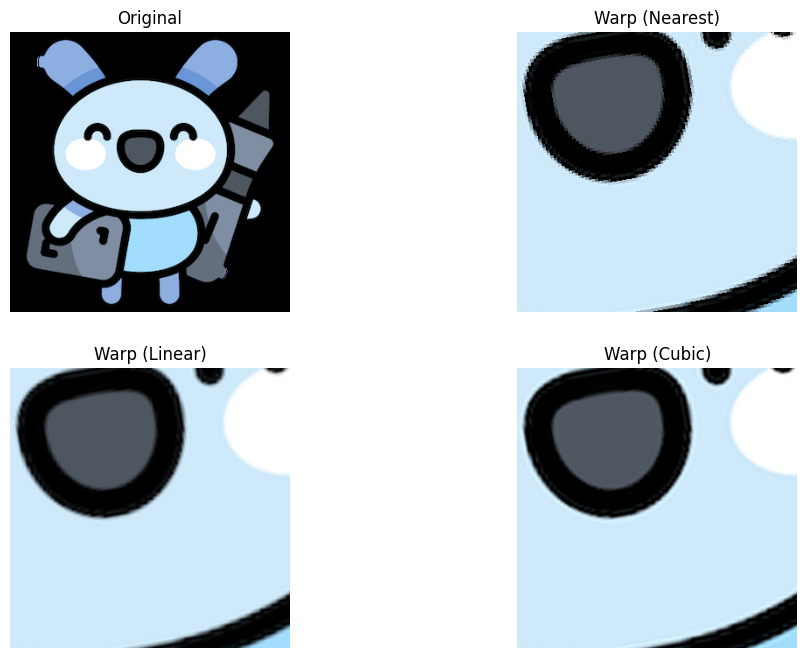

In [55]:
h, w = img.shape[:2]
center = (w/2, h/2)

angle = 10   # degrees
scale = 3.5
M = cv2.getRotationMatrix2D(center, angle, scale)

# แปลงเป็น RGB เพื่อแสดงผลให้สีถูกต้อง
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


warp_nearest = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_NEAREST)
warp_linear  = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR)
warp_cubic   = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC)

plt.figure(figsize=(12,8))
plt.subplot(2,2,1); plt.imshow(img, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(2,2,2); plt.imshow(warp_nearest, cmap="gray"); plt.title("Warp (Nearest)"); plt.axis("off")
plt.subplot(2,2,3); plt.imshow(warp_linear, cmap="gray"); plt.title("Warp (Linear)"); plt.axis("off")
plt.subplot(2,2,4); plt.imshow(warp_cubic, cmap="gray"); plt.title("Warp (Cubic)"); plt.axis("off")
plt.show()